# ITR Tool - Template Temperature Score Calculation

This notebook provides a simple example of the ITR Toolkit as a means to evaluate Portfolio Alignment.  Text boxes (called Markdown cells) like this provide some explanation, and then code cells either do the work just explained or will do work that will be explained.

All data needed to run this demonstration should be local and no acccess to the internet should be required.  However, if you want to delete a file and re-download it (to restore to its pristine state), of course you need access to the internet.

The **Sample Data template** provides both a *Read me* sheet and sheet of data dictionary *Definitions*, as well as three input data sheets:
* ITR input data: The fundamental financial, emissions, and production data of companies, listed by security instrument as company id
* ITR target input data: Short-term Emissions or Intensity reduction targets and Net-Zero attainment target dates, listed by company id
* Portfolio: A list of positions and investment value amounts

The user may choose **Benchmark Data** that forecasts intensity reductions expected from 2020-2050 by region and sector.  By default we use the OECM benchmark, but two TPI benchmarks are also available.  In all three cases we use the same projections for production grwoth forecasts.  We also use the same global carbon budget and TCRE multipliers for all benchmarks.

After scoring the portfolio, the portfolio is copied to the local file *data_dump.xlsx* which can be downloaded for further analysis.

This notebook also outputs an **enhanced portfolio** (with temperature scores), can be aggregated using various weighting methods to gain additional portfolio alignment insights.

Please enjoy learning how the ITR tool works by following the computations performed by this Jupyter Notebook!

## Getting started
Make sure you are running the notebook with the requirements installed available in the example folder.

If you see errors when attempting to load the ITR modules, go to the top-level ITR directory, activate the `itr_env` conda environment (using `conda activate itr_env` and execute the command `pip install -e .`.  Then try again, or hit the <i class="fas fa-forward"></i> button above.

In [1]:
import os
import sys
import warnings

import json
import numpy as np
import pandas as pd

In [2]:
# Load the ITR library files

import ITR
from ITR import data_dir
from ITR.data.excel import ExcelProviderProductionBenchmark, ExcelProviderIntensityBenchmark
from ITR.data.template import TemplateProviderCompany
from ITR.data.base_providers import BaseProviderProductionBenchmark, BaseProviderIntensityBenchmark
from ITR.data.data_warehouse import DataWarehouse
from ITR.portfolio_aggregation import PortfolioAggregationMethod
from ITR.temperature_score import TemperatureScore
from ITR.interfaces import ETimeFrames, EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes

from ITR.data.osc_units import ureg, Q_, PA_, asPintDataFrame, requantify_df_from_columns

from ITR_examples.utils import (
    plot_grouped_heatmap,
    plot_grouped_statistics,
    get_contributions_per_group,
    collect_company_contributions,
)

If all is well, the list of paths below will prioritize loading from the environment established for the ITR tool.  Please contact us if not.

In [3]:
print("Testing unit registry\n=====================")
one_co2 = ureg("CO2e")
print(f"The gas species CO2e, which was a gwp of 1: {one_co2}")

one_Gt_co2 = ureg("Gt CO2e")
print(f"A gigaton of CO2e: {one_Gt_co2}")

Testing unit registry
The gas species CO2e, which was a gwp of 1: 1 CO2e
A gigaton of CO2e: 1 CO2e * gigametric_ton


## Load the production and intensity benchmarks

Prepare the various benchmark files; the OECM benchmark is the default after the next cell finishes.

In [4]:
benchmark_prod_json = os.path.join(data_dir, "benchmark_production_OECM.json")
benchmark_EI_OECM_PC = os.path.join(data_dir, "benchmark_EI_OECM_PC.json")
benchmark_EI_OECM_S3 = os.path.join(data_dir, "benchmark_EI_OECM_S3.json")
benchmark_EI_TPI = os.path.join(data_dir, "benchmark_EI_TPI_2_degrees.json")
benchmark_EI_TPI_below_2 = os.path.join(data_dir, "benchmark_EI_TPI_below_2_degrees.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.model_validate(parsed_json)
base_production_bm = BaseProviderProductionBenchmark(production_benchmarks=prod_bms)

# load intensity benchmarks

# OECM
with open(benchmark_EI_OECM_S3) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.model_validate(parsed_json)
OECM_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

if False:
    # OECM Production-Centric
    with open(benchmark_EI_OECM_PC) as json_file:
        parsed_json = json.load(json_file)
    ei_bms = IEIBenchmarkScopes.model_validate(parsed_json)
    OECM_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

    # TPI
    with open(benchmark_EI_TPI) as json_file:
        parsed_json = json.load(json_file)
    ei_bms = IEIBenchmarkScopes.model_validate(parsed_json)
    TPI_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

    # TPI below 2
    with open(benchmark_EI_TPI_below_2) as json_file:
        parsed_json = json.load(json_file)
    ei_bms = IEIBenchmarkScopes.model_validate(parsed_json)
    TPI_below_2_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

base_intensity_bm = OECM_EI_bm

## Download/load the sample template data

We have prepared sample data from public sources for you to be able to run the tool as it is to familiarise yourself with how it works. To use your own data; please check out to the [Data Template Requirements](https://github.com/os-c/ITR/blob/main/docs/DataTemplateRequirements.rst) section of the technical documentation for more details on data requirements and formatting. 

*The sample data may contain estimates, simplifications, and recategorizations.  It is intended to be generally representative, but not authoritative, and should not be relied upon to make investment decisions.*

In [5]:
template_data_path = os.path.abspath("../src/ITR_examples/data/20220927 ITR V2 Sample Data.xlsx")

### Logging
The ITR module uses the Python standard library logging utilities to send log messages. The log level can be changed according to the user's needs.

In [6]:
import logging

root_logger = logging.getLogger()
root_logger.setLevel("INFO")

## Create a data provider
Data providers let you connect to the data source of your choice. In this case we are connecting to Excel as a data provider for benchmark information and we are using the ITR Data Template for company and portfolio information, using *template_data_path* as the pathname to the data.  If you want to supply your own data file, you can set the pathname in the first line of the next cell.

In [7]:
# Remove the # and space on the next line to point the template_data_path variable at your own data
# template_data_path = "data/your_template_here.xlsx"

template_company_data = TemplateProviderCompany(excel_path=template_data_path)

2023-11-03 07:55:53,285 - ITR.data.template - WARNING - Company DE0005190003 uses multiple units describing scopes ['s1', 's1s2', 's2', 's3']
2023-11-03 07:55:53,286 - ITR.data.template - WARNING - Company US00130H1059 uses multiple units describing scopes ['s1', 's1s2', 's2', 's3']
2023-11-03 07:55:53,286 - ITR.data.template - WARNING - The ITR Tool will choose one and covert all to that
2023-11-03 07:55:53,970 - ITR.data.template - WARNING - Emissions data missing for MultiIndex([('Energy', 'PETRONAS_SOE', 'S1'),
            ('Energy', 'PETRONAS_SOE', 'S2')],
           names=['sector', 'company_id', 'metric'])
2023-11-03 07:55:54,024 - ITR.data.template - WARNING - Scope 3 Emissions data missing for MultiIndex([('Construction Buildings', 'GB0000961622'),
            ( 'Electricity Utilities', 'CA2908761018'),
            ( 'Electricity Utilities', 'CA3495531079'),
            ( 'Electricity Utilities', 'CA87807B1076'),
            ( 'Electricity Utilities', 'US0185223007'),
        

## Create the Data Warehouse

In [8]:
template_company_data._companies[0].production_metric

'GWh'

In [9]:
template_provider = DataWarehouse(
    template_company_data,
    base_production_bm,
    base_intensity_bm,
    estimate_missing_data=DataWarehouse.estimate_missing_s3_data,
)

# Fills in template_company_data._companies[0].projected_targets.S1S2

print(
    f"Benchmark Temperature = {base_intensity_bm.benchmark_temperature}\n\
Benchmark Global Budget = {base_intensity_bm.benchmark_global_budget}\n\
AFOLU included = {base_intensity_bm.is_AFOLU_included}"
)

2023-11-03 07:55:57,018 - ITR.data.data_warehouse - INFO - new_production_bm calculating trajectories for 76 companies (times 5 scopes times 31 years)
2023-11-03 07:55:59,054 - ITR.data.base_providers - INFO - Normalizing intensity metrics
2023-11-03 07:55:59,201 - ITR.data.base_providers - INFO - Done normalizing intensity metrics
2023-11-03 07:55:59,202 - ITR.data.data_warehouse - INFO - estimating missing data
2023-11-03 07:55:59,204 - ITR.data.data_warehouse - INFO - Added S3 estimates for US0185223007 (sector = Electricity Utilities, region = North America)
2023-11-03 07:55:59,207 - ITR.data.data_warehouse - INFO - Added S3 estimates for US0188021085 (sector = Electricity Utilities, region = North America)
2023-11-03 07:55:59,210 - ITR.data.data_warehouse - INFO - Added S3 estimates for US0236081024 (sector = Electricity Utilities, region = North America)
2023-11-03 07:55:59,212 - ITR.data.data_warehouse - INFO - Added S3 estimates for US0255371017 (sector = Electricity Utilities,

Benchmark Temperature = 1.5 delta_degree_Celsius
Benchmark Global Budget = 521.0526315789474 CO2 * gigametric_ton
AFOLU included = False


In [10]:
ureg("kg CO2/(passenger km)")

1.0 <Unit('CO2 * kilogram / pkm')>

## Load your portfolio

The portfolio data is a sheet in the Data Template named "Portfolio".

Please see the technical documentation in the [Data Template Requirements](https://github.com/os-c/ITR/blob/main/docs/DataTemplateRequirements.rst) section for details on data requirements.

In [11]:
df_portfolio = requantify_df_from_columns(pd.read_excel(template_data_path, sheet_name="Portfolio"))
display(df_portfolio.tail())

,company_name,company_lei,company_id,company_isin,investment_value
71,WEC Energy Group,549300IGLYTZUK3PVP70,US92939U1060,US92939U1060,156078372
72,WORTHINGTON INDUSTRIES INC,1WRCIANKYOIK6KYE5E82,US9818111026,US9818111026,150599095
73,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,US98389B1008,145984384
74,Balfour Beatty,CT4UIJ3TUKGYYHMENQ17,GB0000961622,GB0000961622,94590720
75,CBRE,52990016II9MJ2OSWA10,US12504L1098,US12504L1098,50391328


To load the data from the data provider, we have to pass a list of IPortfolioCompany instances. The module has a strict [data model](https://ofbdabv.github.io/ITR/autoapi/ITR/interfaces/index.html) to convert Pandas Dataframe to the right object types we supplied a utility function.


In [12]:
companies = ITR.utils.dataframe_to_portfolio(df_portfolio)

## Calculate the temperature scores
In the enhanced portfolio you'll find your original portfolio, with calculated temperature scores, trajectory and target scores and overshoot/undershoot ration, and a temperature_result which is current set to zero for all valid calculations.

In [13]:
temperature_score_s1s2s3 = TemperatureScore(
    time_frames=[ETimeFrames.LONG],
    scopes=[EScope.S1S2S3],
    aggregation_method=PortfolioAggregationMethod.WATS,  # Options for the aggregation method are WATS, TETS, AOTS, MOTS, EOTS, ECOTS, and ROTS.
)
enhanced_portfolio = temperature_score_s1s2s3.calculate(data_warehouse=template_provider, portfolio=companies)

2023-11-03 07:56:01,017 - ITR.temperature_score - INFO - calculating temperature score for 76 companies
2023-11-03 07:56:07,424 - ITR.temperature_score - INFO - temperature score preparing data
2023-11-03 07:56:07,525 - ITR.temperature_score - INFO - temperature score data prepared


For every company the tool assigns a score for all the requested timeframe and scope combinations. For now the ITR methodolgy only supportt a long timeframe in combination with a S1S2 scope

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(enhanced_portfolio[["company_name", "time_frame", "scope", "temperature_score"]])

,company_name,time_frame,scope,temperature_score
company_id,,,,
US00130H1059,AES Corp.,LONG,S1S2S3,1.9511764615162877
US0185223007,"ALLETE, Inc.",LONG,S1S2S3,3.5202340077128333
US0188021085,Alliant Energy,LONG,S1S2S3,2.251433843906471
US0236081024,Ameren Corp.,LONG,S1S2S3,4.473414472707755
US0255371017,"American Electric Power Co., Inc.",LONG,S1S2S3,3.7259694918985873
...,...,...,...,...
US92939U1060,WEC Energy Group,LONG,S1S2S3,3.186000629173453
US9818111026,WORTHINGTON INDUSTRIES INC,LONG,S1S2S3,1.597149767977132
US98389B1008,"Xcel Energy, Inc.",LONG,S1S2S3,2.483338529630434


In [15]:
data = enhanced_portfolio[
    (enhanced_portfolio.scope == EScope.S1S2S3) & (enhanced_portfolio.temperature_score > Q_(3, "delta_degC"))
]
data

,scope,company_name,sector,region,target_probability,target_data,historic_data,country,emissions_metric,production_metric,...,target_exceedance_year,company_isin,investment_value,time_frame,temperature_score,trajectory_score,trajectory_overshoot_ratio,target_score,target_overshoot_ratio,score_result_type
company_id,,,,,,,,,,,,,,,,,,,,,
US0185223007,S1S2S3,"ALLETE, Inc.",Electricity Utilities,North America,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US0185223007,269631356,LONG,3.5202340077128333,3.5202340077128333,7.45732831409259,nan,nan,TRAJECTORY_ONLY
US0236081024,S1S2S3,Ameren Corp.,Electricity Utilities,North America,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US0236081024,93011236,LONG,4.473414472707755,4.473414472707755,10.50400468007452,nan,nan,TRAJECTORY_ONLY
US0255371017,S1S2S3,"American Electric Power Co., Inc.",Electricity Utilities,North America,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US0255371017,176602242,LONG,3.7259694918985873,3.7259694918985873,8.114926177594675,nan,nan,TRAJECTORY_ONLY
US0921131092,S1S2S3,Black Hills Corp.,Electricity Utilities,North America,0.5,[netzero_year=None target_type='intensity' tar...,"productions=[IProductionRealization(year=2016,...",US,t CO2e,MWh,...,2019.0,US0921131092,243360405,LONG,3.0486567675371825,3.0486567675371825,5.950013293336478,nan,nan,TRAJECTORY_ONLY
US1258961002,S1S2S3,CMS Energy Corp.,Electricity Utilities,North America,0.5,[netzero_year=None target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US1258961002,120827925,LONG,4.639153535086694,4.639153535086694,11.033760904435045,nan,nan,TRAJECTORY_ONLY
US18551QAA58,S1S2S3,Cleco Partners LP,Electricity Utilities,North America,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US18551QAA58,202777551,LONG,4.968912274661995,4.968912274661995,12.087777636036243,nan,nan,TRAJECTORY_ONLY
US2091151041,S1S2S3,"Consolidated Edison, Inc.",Electricity Utilities,North America,0.5,[netzero_year=2040 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US2091151041,175585595,LONG,3.314435159751554,3.314435159751554,6.799527919249962,nan,nan,TRAJECTORY_ONLY
US2333311072,S1S2S3,DTE Energy,Electricity Utilities,North America,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",US,Mt CO2e,TWh,...,2019.0,US2333311072,136659250,LONG,7.291605657906049,7.291605657906049,19.511864989935145,nan,nan,TRAJECTORY_ONLY
FR0010242511,S1S2S3,Electricité de France,Electricity Utilities,Europe,0.5,[netzero_year=2050 target_type='absolute' targ...,"productions=[IProductionRealization(year=2016,...",FR,Mt CO2e,GWh,...,2019.0,FR0010242511,190510040,LONG,4.191830879848466,4.464312594747323,10.474912102659761,4.191830879848466,9.603971466094158,TARGET_ONLY


## Calculate the aggregated temperature score
Calculate an aggregated temperature score. This can be done using different aggregation methods. Here we'll use the "Weighted Average Temperature Score" (WATS) by initializing the TemperatureScore Object with PortfolioAggregationMethod.WATS. The temperature scores are calculated per time-frame/scope combination.


In [16]:
aggregated_scores = temperature_score_s1s2s3.aggregate_scores(enhanced_portfolio)
print(f"Temperature Score aggregation method = {temperature_score_s1s2s3.aggregation_method}")

Temperature Score aggregation method = PortfolioAggregationMethod.WATS


In [17]:
aggregated_scores.long.S1S2S3.all.score

2.680138894037355 <Unit('delta_degree_Celsius')>

## Display aggregation data in various ways


The first analysis of your portfolio could be to understand if you have any particular hotspots in your portfolio. We can do that by analysing different groupings of companies.

The tool allows you to calculate temperature scores for _groups_ of companies. In this example we group the scores by sector and region, and leave the timeframe and scope unchanged. Any categorical variable in the data provided by you or your data provider (in the `test_company_data.xlsx` imported above) can be used as grouping variable, e.g. sectors, industries, regions, countries, market cap buckets, as well as the additional fields you imported via the portfolio data.

You can change the variable by which the data is grouped by replacing the fourth line in the following cell. For example, replacing "grouping=['sector', 'region']" by "grouping=['sector', 'country']" would result in temperature scores per sector per country. 
If you want to change the time frame as well, please refer to the section 'Calculate the company temperature scores' above.



In [18]:
grouping = ["sector", "region"]
temperature_score_s1s2s3.grouping = grouping
grouped_portfolio = temperature_score_s1s2s3.calculate(data_warehouse=template_provider, portfolio=companies)
grouped_aggregations = temperature_score_s1s2s3.aggregate_scores(grouped_portfolio)

2023-11-03 07:56:07,927 - ITR.temperature_score - INFO - calculating temperature score for 76 companies
2023-11-03 07:56:14,225 - ITR.temperature_score - INFO - temperature score preparing data
2023-11-03 07:56:14,321 - ITR.temperature_score - INFO - temperature score data prepared



The aggregated scores can then be used, for example, to show the relation between sectors and regions with respect to temperature score.
A visualization of this relation is shown in the heatmap below. The grey fields indicate that the portfolio contains no assest for those combinations.

#### Quick analysis: Heat Map

We can see here that our North American Steel is in reasonable shape. While Asian Steel can be improved as shown in the drill down below the graph



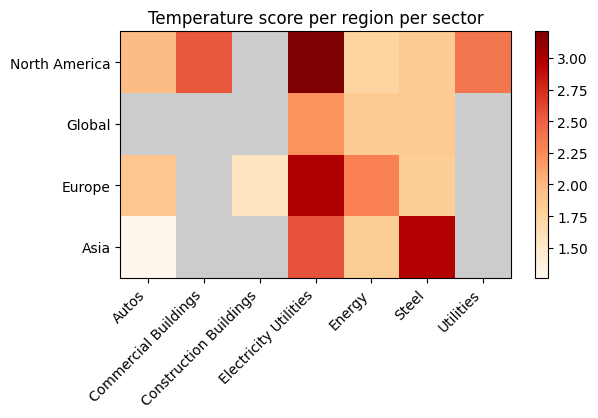

In [19]:
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2S3], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)

In [20]:
region = "Europe"
sector = "Steel"
group = sector + "-" + region
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2S3], grouping)
group_contributions = get_contributions_per_group(grouped_aggregations, analysis_parameters, group)
group_contributions.round(2)

,group,company_name,company_id,temperature_score,contribution_relative
0,Steel-Europe,TENARIS SA,US88031M1099,1.6912879763614752 delta_degree_Celsius,60.78670766981185 percent
1,Steel-Europe,TERNIUM S.A.,US8808901081,2.035927773982995 delta_degree_Celsius,39.21329233018816 percent


#### Sector analysis

Sector analysis may help us with bringing some clarity into our analysis from the heatmap above. In order to identify the companies that your portfolio would most benefit from engaging with, we can start with identifying the biggest contributing sectors to the portfolio's temperature score, as in our example below.

Contributions can be identified on an individual company level, as well as contributions from companies grouped by one of their characteristics, e.g. sector or region. The exact definitions of companies' contributions to the portfolio temperature scores depend on the selected aggregation method.

You can group companies on any categorical variable (e.g. sectors, countries, market cap buckets, investment strategies, etc)  you provide through your dataprovider, in this example in the test_company_data.xlsx imported above.

For our analysis we select one time-frame (LONG) and one scope (S1+S2) and group the outcomes on sector and compare AUM to temperature score contribution. We also then display the sector temperature scores.

#### Quick analysis

In this example we can see that both sectors Steel and Electricity are scoring above 2.0C. 


In [21]:
time_frames = [ETimeFrames.LONG]
scopes = [EScope.S1S2, EScope.S3]
grouping = ["sector"]
analysis_parameters = (time_frames, scopes, grouping)

temperature_score_s1s2_s3 = TemperatureScore(
    time_frames=time_frames, scopes=scopes, grouping=grouping, aggregation_method=PortfolioAggregationMethod.WATS
)
enhanced_portfolio = temperature_score_s1s2_s3.calculate(data_warehouse=template_provider, portfolio=companies)
aggregated_portfolio = temperature_score_s1s2_s3.aggregate_scores(enhanced_portfolio)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    company_contributions = collect_company_contributions(aggregated_portfolio, enhanced_portfolio, analysis_parameters)

2023-11-03 07:56:15,304 - ITR.temperature_score - INFO - calculating temperature score for 76 companies
2023-11-03 07:56:21,607 - ITR.temperature_score - INFO - temperature score preparing data
2023-11-03 07:56:21,677 - ITR.temperature_score - INFO - temperature score data prepared


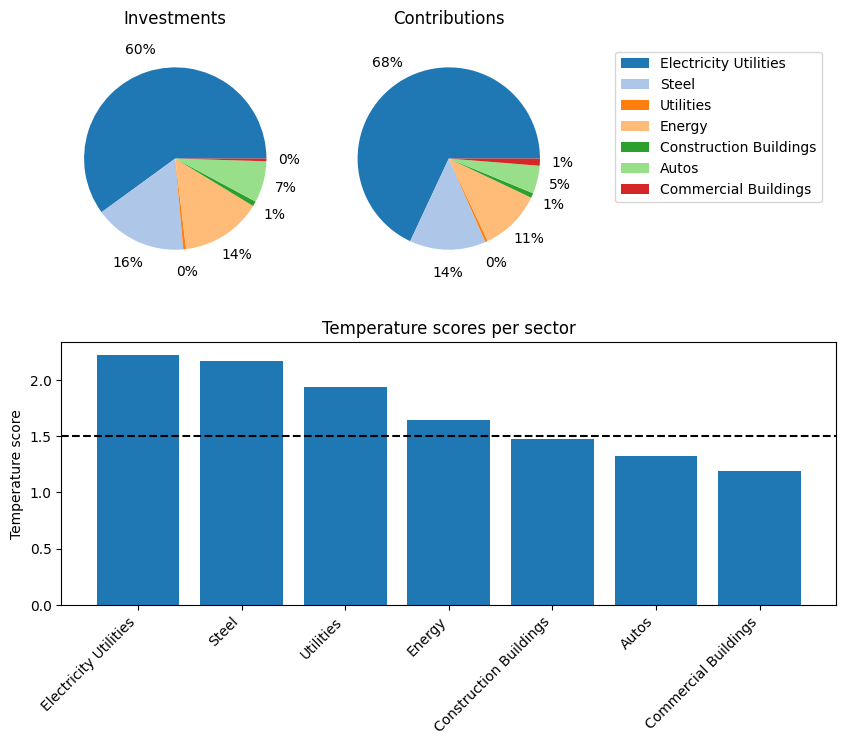

In [22]:
plot_grouped_statistics(
    aggregated_portfolio, company_contributions.pint.dequantify().droplevel(level=1, axis=1), analysis_parameters
)

We can use what we learned from this analysis to drill into a few of the highest contributing scoring sectors to see which
companies are the biggest contributors on the sector level. Considering the Steel sector, for instance, in the
table below.


In [23]:
sector_contributions = company_contributions[
    [
        "company_name",
        "company_id",
        "sector",
        "contribution",
        "temperature_score",
        "ownership_percentage",
        "portfolio_percentage",
    ]
]
asPintDataFrame(sector_contributions[sector_contributions["sector"] == "Steel"][:10]).pint.dequantify().round(2)

,company_name,company_id,sector,contribution,temperature_score,ownership_percentage,portfolio_percentage
unit,No Unit,No Unit,No Unit,percent,delta_degree_Celsius,dimensionless,dimensionless
5,CARPENTER TECHNOLOGY CORP,US1442851036,Steel,3.1,4.07,9.89,0.39
4,CARPENTER TECHNOLOGY CORP,US1442851036,Steel,3.1,4.07,9.89,0.39
13,NIPPON STEEL CORP,JP3381000003,Steel,2.27,3.06,1.99,0.38
12,NIPPON STEEL CORP,JP3381000003,Steel,2.27,3.06,1.99,0.38
49,TIMKENSTEEL CORP,US8873991033,Steel,1.62,1.52,69.02,0.55
48,TIMKENSTEEL CORP,US8873991033,Steel,1.62,1.52,69.02,0.55
51,UNITED STATES STEEL CORP,US9129091081,Steel,1.55,1.8,7.24,0.44
50,UNITED STATES STEEL CORP,US9129091081,Steel,1.55,1.8,7.24,0.44
58,TENARIS SA,US88031M1099,Steel,1.37,2.17,23.43,0.32


### Save portfolio data for further analysis
To take your analysis outside of this notebook and for example for internal and client reporting, you can export all data to Excel and the clipboard for pasting into and analysing in other applications.

If you run the ITR tool locally or from Google Colab, you:
- Specify the filenames of the output files in the cell below, e.g. change 'data_dump.xlsx' in the first line to 'TS_output.xlsx'
- Run the cell below

In [24]:
data_dump_filename = "data_dump.xlsx"
enhanced_portfolio.set_index(["company_name"], append=True).to_excel(data_dump_filename)

In [25]:
data_dump_filename = "data_dump_dequantified.xlsx"
enhanced_portfolio.set_index(["company_name"], append=True).pint.dequantify().to_excel(data_dump_filename)

### Compare OECD and non-OECD results

There are currently 37 members of the OECD (text list maintained on the OECD website).  We use a simple CSV file containing data correct as of June 6th, 2022.

In [26]:
from ITR.utils import get_project_root

pkg_root = get_project_root()

# When connected to the Data Commons, this would be the kind of data we could simply load from a table.
# As this is a stand-alone program, we must load the data from a file.

oecd_df = pd.read_csv(f"{pkg_root}/data/input/oecd_iso.csv")

We reuse the calculated `grouped_portfolio` from above, and then add the additional OECD discriminator to it.  We can add arbitrary columns and group on them in this way.  (And of course we can recompute a fresh `grouped_portfolio` if we wish.)

Because of the way we generate grouped and aggregated data (which uses dash (-) as a separator), we spell Non-OECD with an underscore  (non_oecd) instead of a dash.

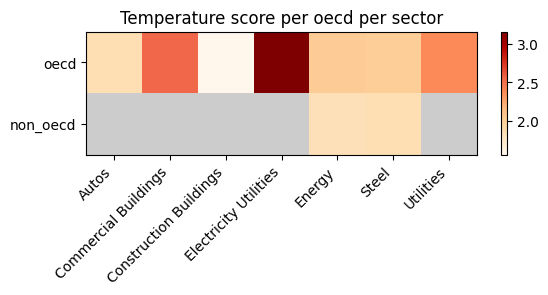

In [27]:
grouping = ["sector", "oecd"]
grouped_portfolio.loc[:, "oecd"] = grouped_portfolio.country.map(
    lambda x: "oecd" if x in oecd_df.alpha_2.values else "non_oecd"
)
temperature_score_s1s2s3.grouping = grouping
grouped_aggregations = temperature_score_s1s2s3.aggregate_scores(grouped_portfolio)
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2S3], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)